wafer : 반도체의 얇은 판

In [1]:
import os
from os.path import join

import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
import keras
from keras import layers, Input, models
#from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

datapath = join('data', 'wafer')

#print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_pickle("/content/drive/Shareddrives/TNT/정규세션/2022년 1학기/산업 인공지능/TASK2-wafer map /LSWMD.pkl")

In [4]:
#[[]] 꼴로 있던 brackets 제거

def removebrackets(array):
    if array.shape == (1, 1):
        return "".join(array[0])
    elif array.shape == (0, 0):
        return None
        
df.rename(columns = {'trianTestLabel':'TrainTestLabel'}, inplace = 'True')
df['TrainTestLabel'] = df['TrainTestLabel'].apply(removebrackets)
df['failureType'] = df['failureType'].apply(removebrackets)

In [ ]:
df.head()

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none


In [5]:
df_replace=df.dropna() #df에 있던 모든 결측치행 제거.

In [ ]:
df_replace.isna().sum() 

waferMap          0
dieSize           0
lotName           0
waferIndex        0
TrainTestLabel    0
failureType       0
dtype: int64

In [ ]:
df_replace

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none
...,...,...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,Test,Edge-Loc
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,Test,Edge-Loc
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc


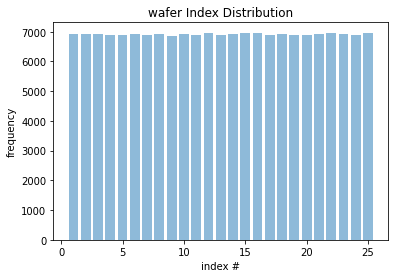

In [ ]:
#wafer Index의 분포 - 고르게 분포한다는 것을 알 수 있다.
#                 - 분포가 고르니까 필요x

import matplotlib.pyplot as plt
%matplotlib inline

uni_Index=np.unique(df_replace.waferIndex, return_counts=True)
plt.bar(uni_Index[0], uni_Index[1], align='center', alpha=0.5)
plt.title("wafer Index Distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.show()

In [6]:
# waferIndex 고르게 분포 -> 제거
df_replace= df_replace.drop(['waferIndex'], axis = 1)

In [ ]:
df_replace.head()

,waferMap,dieSize,lotName,TrainTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none


In [7]:
#diesize = 공정의 순서와 관련된 값으로 분류모델과 무관 -> 제거
df_replace=df_replace.drop(['dieSize'],axis=1)

In [8]:
#waferMap 이 몇차원으로 주어졌는지 확인
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0, dim1
    
df_replace['waferMapDim']=df_replace.waferMap.apply(find_dim)

In [ ]:
df_replace

,waferMap,lotName,TrainTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",lot1,Training,none,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",lot1,Training,none,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",lot1,Training,none,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",lot1,Training,none,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",lot1,Training,none,"(45, 48)"
...,...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",lot47542,Test,Edge-Loc,"(26, 30)"
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",lot47542,Test,Edge-Loc,"(26, 30)"
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",lot47542,Test,Edge-Ring,"(26, 30)"
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",lot47542,Test,Edge-Loc,"(26, 30)"


In [ ]:
#LOT 은 wafer 25을 묶음부르는 표현
#1 lot = 25 wafers
#lotName 열 삭제
del df_replace["lotName"]

In [ ]:
df_replace

,waferMap,TrainTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,none,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,none,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,none,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,none,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Training,none,"(45, 48)"
...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",Test,Edge-Loc,"(26, 30)"
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",Test,Edge-Loc,"(26, 30)"
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",Test,Edge-Ring,"(26, 30)"
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",Test,Edge-Loc,"(26, 30)"


In [9]:
df_replace['failureNum']=df_replace.failureType
df_replace['trainTestNum']=df_replace.TrainTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df_replace=df_replace.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [ ]:
del(df_replace['failureType'])
del(df_replace['TrainTestLabel'])

In [ ]:
df_replace.head()

,waferMap,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",8,0


In [ ]:
#type알아보기
type(df_replace.failureNum[0])

numpy.int64

In [ ]:
df_replace.groupby("waferMapDim").size().sort_values(ascending=False)[:20]

waferMapDim
(25, 27)    18781
(26, 26)    14366
(30, 34)    12400
(29, 26)    11751
(27, 25)    10682
(39, 37)    10173
(33, 29)     8125
(42, 44)     6724
(44, 41)     6134
(41, 33)     5091
(35, 31)     4331
(25, 26)     4174
(41, 38)     4152
(33, 37)     3729
(29, 27)     2872
(45, 42)     2648
(43, 44)     2578
(41, 40)     2572
(41, 45)     2313
(38, 36)     2127
dtype: int64

In [ ]:
df

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none
...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,Test,Edge-Ring
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,None,None


In [ ]:
df_withlabel = df_replace[(df_replace['failureNum']>=0) & (df_replace['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()

In [ ]:
df_withlabel

,index,waferMap,waferMapDim,failureNum,trainTestNum
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",8,0
1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",8,0
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",8,0
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",8,0
4,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",8,0
...,...,...,...,...,...
172945,811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...","(26, 30)",2,1
172946,811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...","(26, 30)",2,1
172947,811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...","(26, 30)",3,1
172948,811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...","(26, 30)",2,1


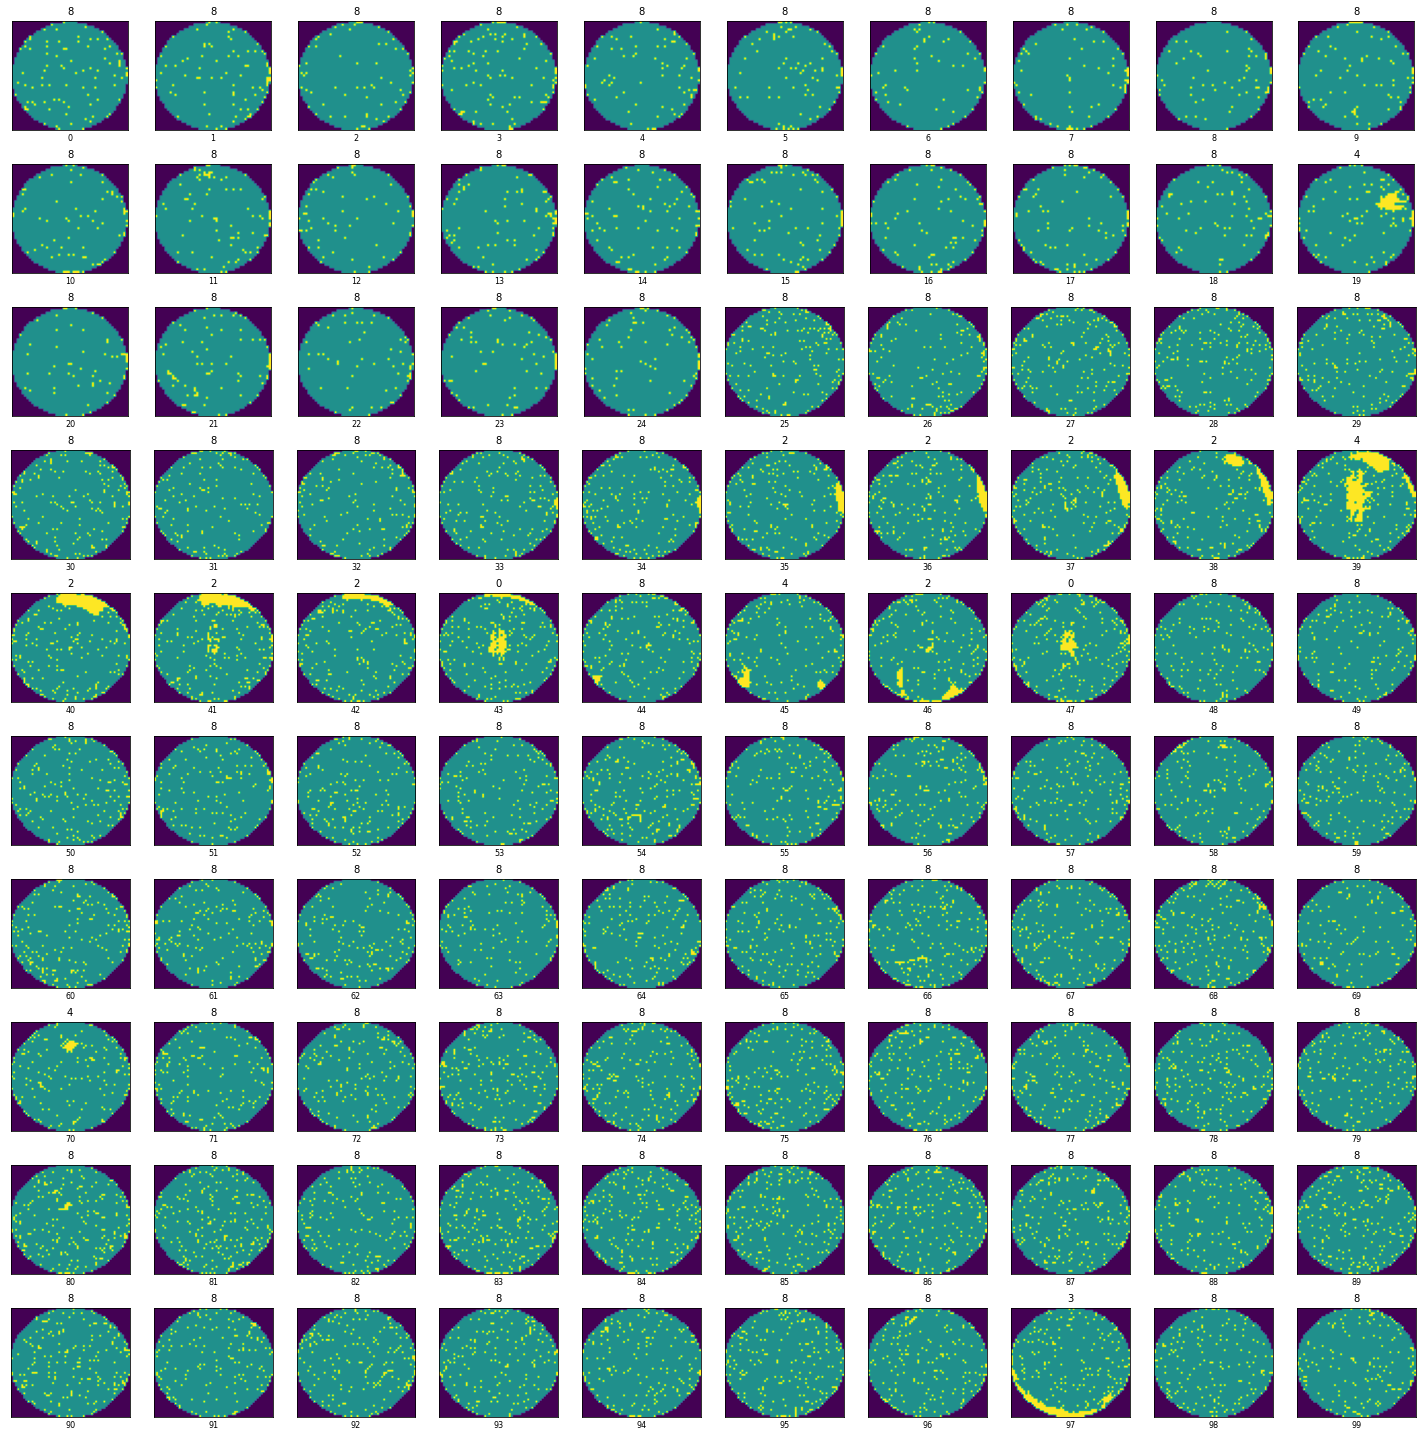

In [ ]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_withlabel.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withlabel.failureNum[i], fontsize=10)
    ax[i].set_xlabel(df_withlabel.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

In [ ]:
df_withpattern = df_replace[(df_replace['failureNum']>=0) & (df_replace['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()

In [ ]:
df_withpattern

,index,waferMap,waferMapDim,failureNum,trainTestNum
0,19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",4,0
1,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(53, 58)",2,0
2,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(53, 58)",2,0
3,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(53, 58)",2,0
4,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(53, 58)",2,0
...,...,...,...,...,...
25514,811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...","(26, 30)",2,1
25515,811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...","(26, 30)",2,1
25516,811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...","(26, 30)",3,1
25517,811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...","(26, 30)",2,1


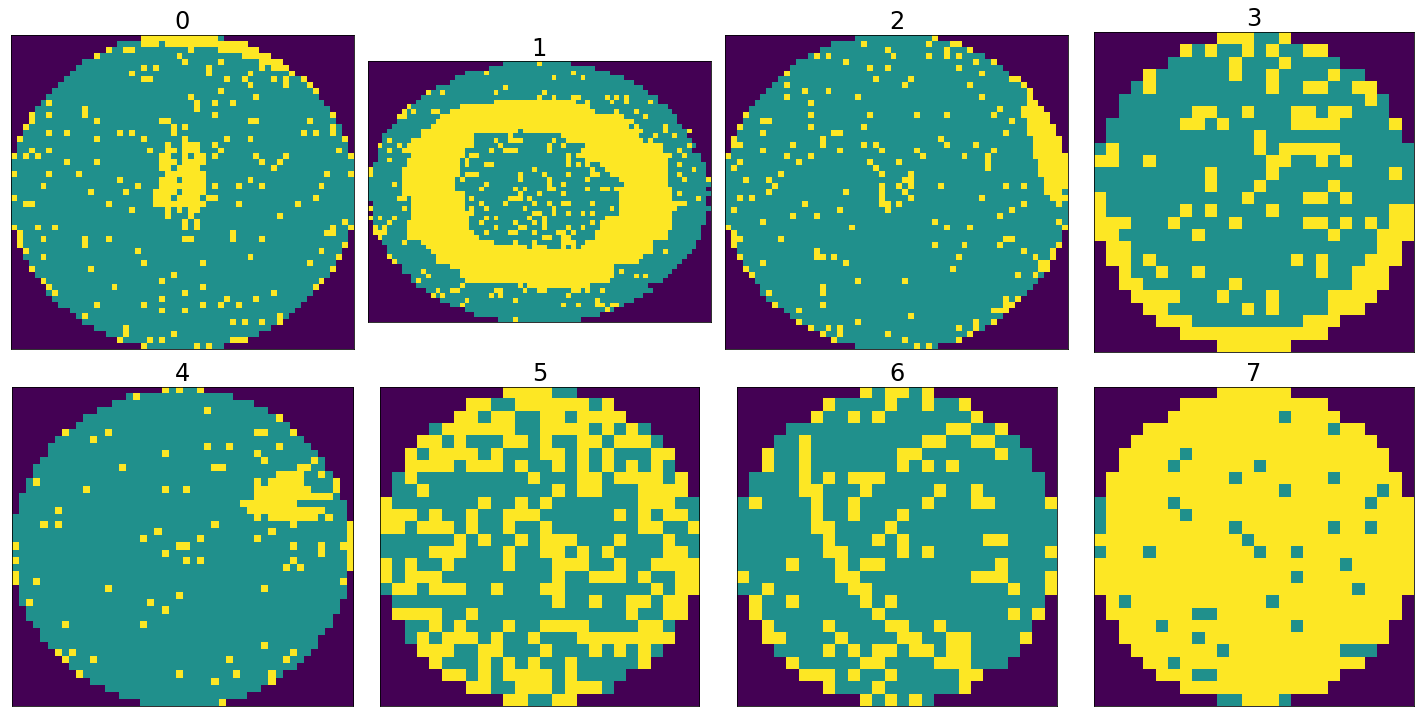

In [ ]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

#ind_def = {'Center': 9, 'Donut': 340, 'Edge-Loc': 3, 'Edge-Ring': 16, 'Loc': 0, 'Random': 25,  'Scratch': 84, 'Near-full': 37}
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureNum[x[i]],fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

In [ ]:
df_replace.waferMapDim

0         (45, 48)
1         (45, 48)
2         (45, 48)
3         (45, 48)
4         (45, 48)
            ...   
811450    (26, 30)
811451    (26, 30)
811452    (26, 30)
811453    (26, 30)
811454    (26, 30)
Name: waferMapDim, Length: 172950, dtype: object

In [ ]:
uni_Index=np.unique(df_replace.waferMapDim, return_counts=True)
uni_Index

(array([(15, 3), (18, 4), (18, 44), (22, 35), (22, 50), (24, 13), (24, 18),
        (25, 26), (25, 27), (26, 25), (26, 26), (26, 28), (26, 30),
        (26, 50), (27, 15), (27, 25), (27, 27), (27, 30), (28, 26),
        (28, 28), (28, 30), (28, 35), (29, 24), (29, 26), (29, 27),
        (29, 28), (29, 29), (29, 30), (29, 35), (29, 45), (30, 30),
        (30, 31), (30, 34), (30, 35), (30, 38), (30, 40), (31, 24),
        (31, 28), (31, 31), (31, 32), (31, 33), (32, 29), (32, 31),
        (32, 32), (32, 33), (32, 35), (32, 36), (33, 24), (33, 29),
        (33, 32), (33, 33), (33, 35), (33, 37), (34, 31), (34, 34),
        (34, 35), (34, 36), (35, 31), (35, 33), (35, 34), (35, 35),
        (35, 36), (35, 37), (35, 38), (35, 40), (36, 30), (36, 34),
        (36, 35), (36, 36), (36, 38), (36, 41), (37, 31), (37, 37),
        (37, 40), (37, 42), (37, 55), (38, 36), (38, 38), (38, 39),
        (38, 40), (38, 41), (38, 42), (38, 45), (38, 62), (39, 31),
        (39, 37), (39, 39), (39, 44), (3

In [ ]:
df_cnt=pd.DataFrame(df_replace['waferMapDim'].value_counts())

KeyError: ignored

In [ ]:
df_cnt=df_cnt.reset_index()
df_cnt

,index,waferMapDim
0,"(25, 27)",18781
1,"(26, 26)",14366
2,"(30, 34)",12400
3,"(29, 26)",11751
4,"(27, 25)",10682
...,...,...
341,"(68, 72)",1
342,"(29, 45)",1
343,"(38, 62)",1
344,"(43, 133)",1


In [ ]:
#size 따른른 waferMapDim개수
df_cnt

,index,waferMapDim
0,"(25, 27)",18781
1,"(26, 26)",14366
2,"(30, 34)",12400
3,"(29, 26)",11751
4,"(27, 25)",10682
...,...,...
341,"(68, 72)",1
342,"(29, 45)",1
343,"(38, 62)",1
344,"(43, 133)",1


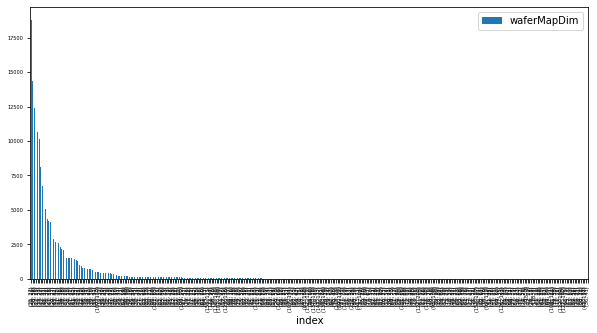

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df_cnt.plot.bar('index','waferMapDim',fontsize=5,figsize=(10,5),rot=90)


plt.show()

In [ ]:
df_replace

,waferMap,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",8,0
...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...","(26, 30)",2,1
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...","(26, 30)",2,1
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...","(26, 30)",3,1
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...","(26, 30)",2,1


In [10]:
import cv2
def cubic_resize(x):
  resized_x=cv2.resize(x,dsize=(32,32),interpolation=cv2.INTER_CUBIC)
  return resized_x
  
def find_dim(x):
  dim0=np.size(x,axis=0)
  dim1=np.size(x,axis=1)
  return dim0,dim1

In [11]:
df_replace['resized_wafer']=df_replace.waferMap.apply(cubic_resize)

In [ ]:
df_replace

,waferMap,waferMapDim,failureNum,trainTestNum,resized_wafer
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",8,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,..."
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",8,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,..."
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",8,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,..."
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",8,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,..."
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(45, 48)",8,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,..."
...,...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...","(26, 30)",2,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1,..."
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...","(26, 30)",2,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,..."
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...","(26, 30)",3,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1,..."
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...","(26, 30)",2,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,..."


In [12]:
#짝수로 resizing 하는 것이 더 좋기 때문에 (32,32)으로 resize 하겠다.
width=32

In [13]:
#resizing
import numpy as np

images=df_replace.resized_wafer.values
labels=df_replace.failureNum.values
X=np.zeros((len(images),width,width))

for i in range(len(images)):
  X[i,:,:]=images[i]
X=X.reshape((-1,width,width,1))

print(X.shape)
#print(labels,X.shape)

new_x=np.zeros((X.shape[0],width,width,3))

for w in range(X.shape[0]):
  for i in range(width):
    for j in range(width):
      new_x[w,i,j,int(X[w,i,j])-1]=1

(172950, 32, 32, 1)


In [ ]:
del X,images

In [ ]:
labels=np.array(df_replace.failureNum)

In [ ]:
import pickle

with open("new_x.pickle","wb") as fw:
  pickle.dump(new_x,fw)
with open("labels.pickle","wb") as fw:
  pickle.dump(labels,fw)

In [ ]:
import pickle

with open("new_x.pickle","rb") as fr:
  new_x=pickle.load(fr)
with open("labels.pickle","rb") as fr:
  labels = pickle.load(fr)

In [ ]:
# train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
encoder=LabelEncoder()
encoded_labels=encoder.fit_transform(labels)
x_train,x_test,y_train,y_test=train_test_split(new_x,encoded_labels,test_size=0.2,shuffle=True,stratify=encoded_labels,random_state=42)
unaugmented_x_train=x_train
unaugmented_y_train=y_train

In [ ]:
faulty_case=np.unique(pd.DataFrame(encoder.inverse_transform(y_train)))
faulty_case

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
# unaugumented model
#증강하지 않은 모델

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, Input,models

In [ ]:
#train
y_train=encoder.inverse_transform(y_train)

In [ ]:
#CNN 모델
def create_model(width=32):
  input_shape=(width,width,3)
  input_tensor=Input(input_shape)
  conv_1=layers.Conv2D(16,(3,3),activation='relu',padding='same')(input_tensor)
  conv_1=layers.MaxPool2D(pool_size=2)(conv_1)

  conv_2=layers.Conv2D(64,(3,3),activation='relu',padding='same')(conv_1)
  conv_2=layers.MaxPool2D(pool_size=2)(conv_2)

  conv_3=layers.Conv2D(128,(3,3),activation='relu',padding='same')(conv_2)
  conv_3=layers.MaxPool2D(pool_size=2)(conv_3)

  flat=layers.Flatten()(conv_3)
  dense_1=layers.Dense(512,activation='relu')(flat)
  dense_2=layers.Dense(128,activation='relu')(dense_1)
  output_tensor=layers.Dense(9,activation='softmax')(dense_2)

  model=models.Model(input_tensor,output_tensor)
  model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

  return model

In [ ]:
unaugumented_model=KerasClassifier(build_fn=create_model,epochs=10,batch_size=128,verbose=2)
hist=unaugumented_model.fit(unaugmented_x_train,unaugmented_y_train)

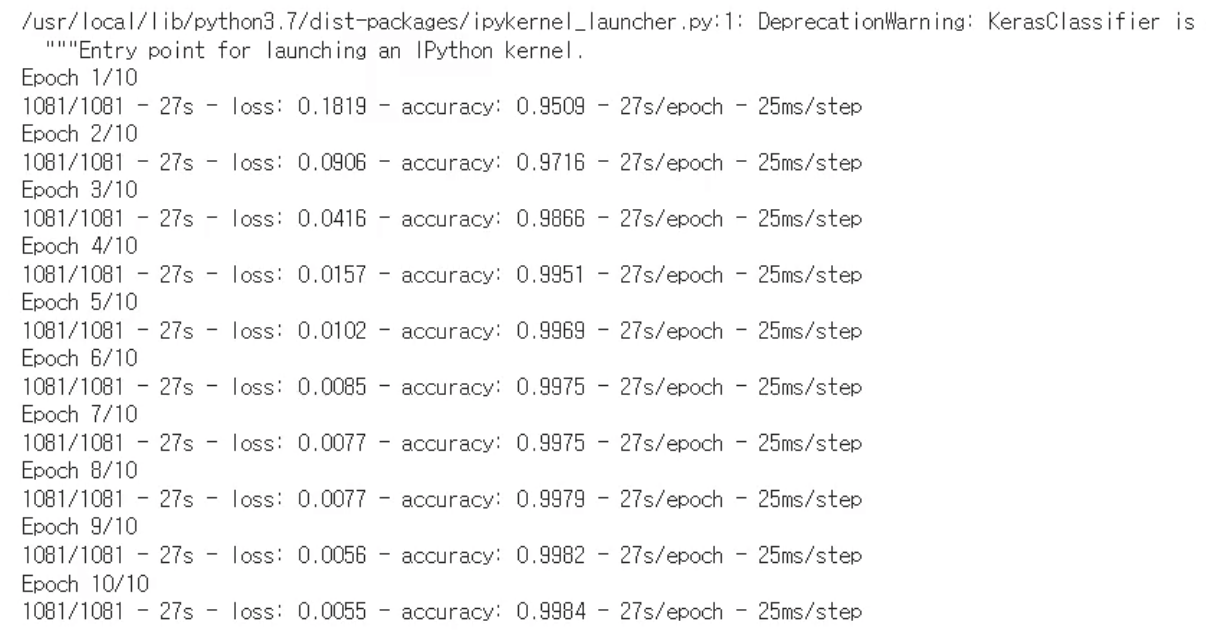

In [ ]:
fig,loss_ax=plt.subplots()
acc_ax=loss_ax.twinx()
loss_ax.plot(hist.history['loss'],label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend()

acc_ax.plot(hist.history['accuracy'],'k',label='train acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend()

plt.show()

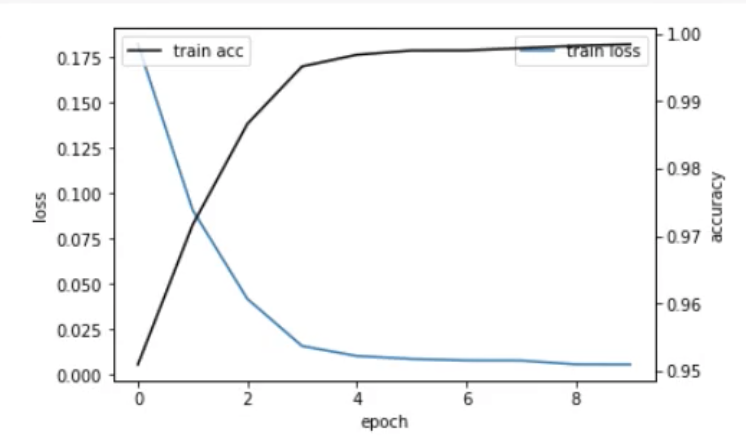

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true=y_test
y_pred=unaugumented_model.predict(x_test)
plt.figure(figsize=(16,14))
sns.heatmap(confusion_matrix(encoder.inverse_transform(y_true),
                             encoder.inverse_transform(y_pred),
                             normalize='true',labels=faulty_case)*100,
            annot=True,cmap='Blues',xticklabels=faulty_case,ytickslabels=faulty_case)

plt.title("CONFUSION MATRIX of the unaugumented test dataset",fontsize=25)
plt.show()
f1score_=f1_score(encoder.inverse_transform(y_true),encoder.inverse_transform(y_pred),
                  labels=faulty_case,average='micro')
print('f1score:',round(f1score_*100,3))

NameError: ignored

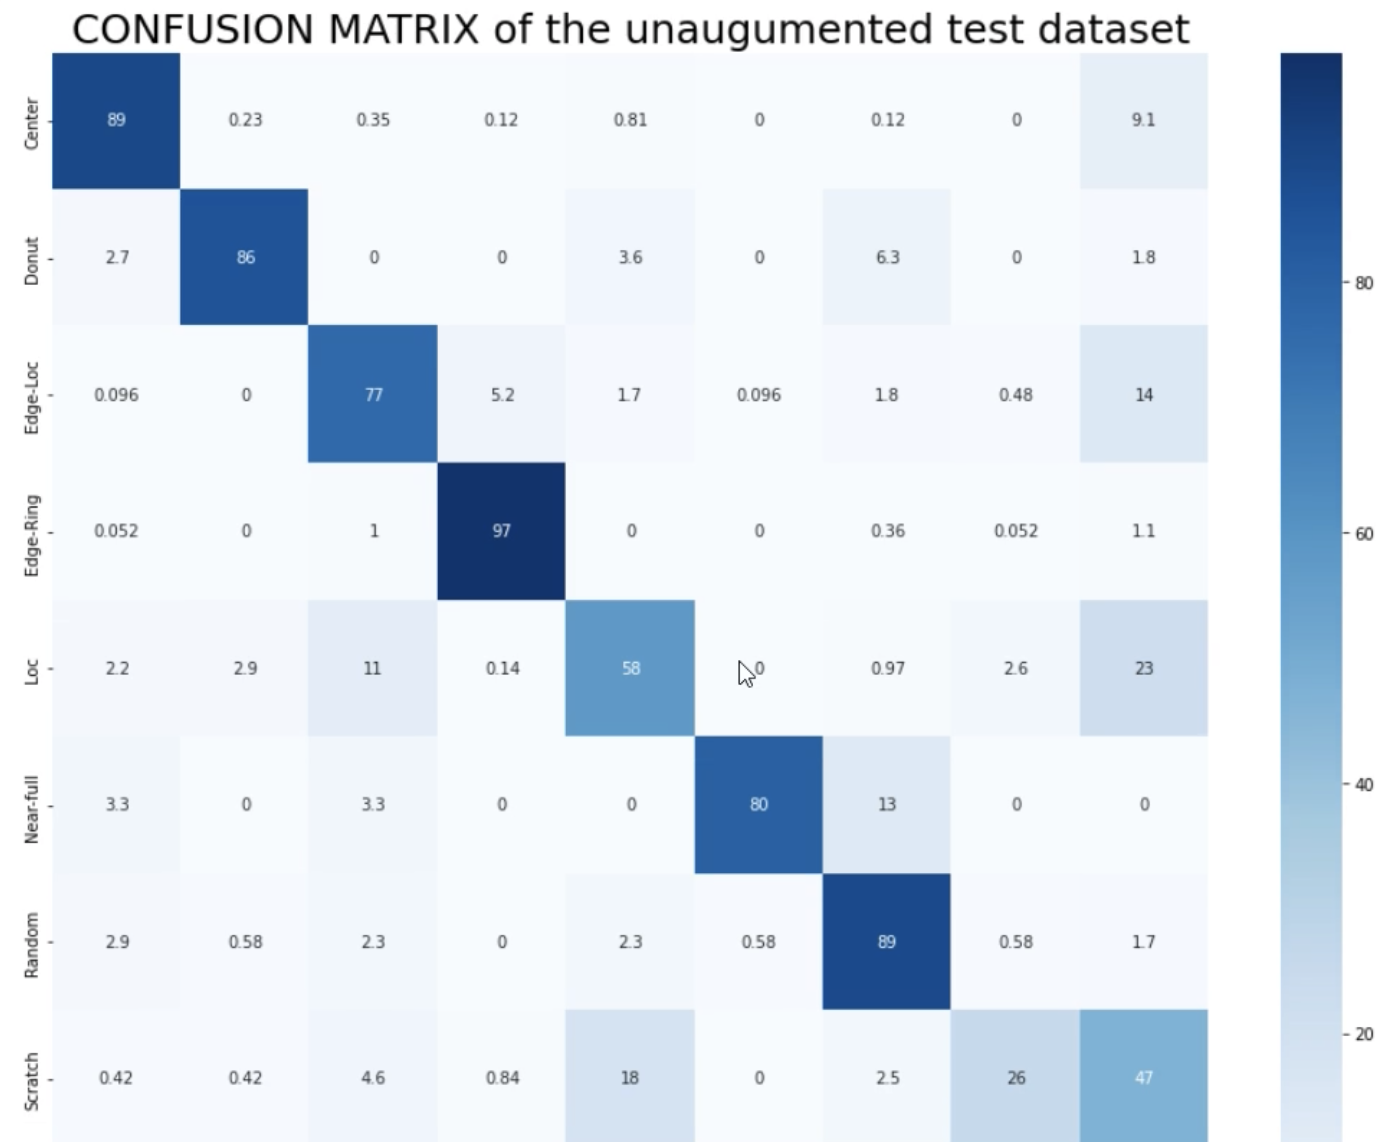

In [ ]:
#None 이라고고 잘못예측많이함